In [1]:
using Pkg
Pkg.activate(raw"libs/")
# Pkg.instantiate()
# Pkg.add("ImageView")
using Lux, NNlib, Zygote, LuxCUDA, CUDA, JLD2, DICOM
using Images, ImageView
using MLUtils
using Optimisers, ProgressBars
using ImageMorphology, ChainRulesCore, Statistics

CUDA.allowscalar(false)

valid_data_dir = raw"C:\Users\wenbl13\Desktop\BAC\collected_dataset_for_ML\valid"
saved_model_dir = raw"C:\Users\wenbl13\Desktop\BAC\BAC Project"
patch_size = 256
patch_size_half = round(Int, patch_size/2);

  Activating project at `c:\Users\wenbl13\Desktop\BAC\BAC Project\libs`

# Helper functions

In [2]:
_conv = (in, out) -> Conv((3, 3), in=>out, pad=1)

conv1 = (in, out) -> Chain(_conv(in, out), BatchNorm(out, leakyrelu))
# conv2 = (in, out) -> Chain(_conv(in, out), x -> softmax(x; dims = 3))
conv2 = (in, out) -> Chain(Conv((1, 1), in=>out), sigmoid)

_tran = (in, out) -> ConvTranspose((2, 2), in => out, stride = 2)
tran = (in, out) -> Chain(_tran(in, out), BatchNorm(out, leakyrelu))

my_cat = (x, y) -> cat(x, y; dims=Val(3))

function unet2D(in_chs, lbl_chs)    
    # Contracting layers
    l1 = Chain(conv1(in_chs, 64), conv1(64, 64))
    l2 = Chain(l1, MaxPool((2,2), stride=2), conv1(64, 128), conv1(128, 128))
    l3 = Chain(l2, MaxPool((2,2), stride=2), conv1(128, 256), conv1(256, 256))
    l4 = Chain(l3, MaxPool((2,2), stride=2), conv1(256, 512), conv1(512, 512))
    l5 = Chain(l4, MaxPool((2,2), stride=2), conv1(512, 1024), conv1(1024, 1024), tran(1024, 512))
    
    # Expanding layers
    l6 = Chain(Parallel(my_cat,l5,l4), conv1(512+512, 512), conv1(512, 512), tran(512, 256))
    l7 = Chain(Parallel(my_cat,l6,l3), conv1(256+256, 256), conv1(256, 256), tran(256, 128))
    l8 = Chain(Parallel(my_cat,l7,l2), conv1(128+128, 128), conv1(128, 128), tran(128, 64))
    l9 = Chain(Parallel(my_cat,l8,l1), conv1(64+64, 64), conv1(64, 64), conv2(64, lbl_chs))
end

function zoom_pxiel_values(img)
    a, b = minimum(img), maximum(img)
    img_ = (img .- a) ./ (b - a)
    return img_
end

function normalize_img(img)
    m = maximum(img)
    img = m .- img
    a = mean(img)
    s = std(img)
    img = (img .- a) ./ s 
    # println("mean = $(mean(img)), std = $(std(img))")
    return img
end

function get_num_of_forgound_patches(mask, s)
    x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
    y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)
    ct = 0
    for i = 1 : x-1
        x_start = 1+(i-1)*patch_size_half
        x_end = x_start+patch_size-1
        for j = 1 : y-1
            y_start = 1+(j-1)*patch_size_half
            y_end = y_start+patch_size-1
            # check patch
            if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
                ct += 1
            end
        end
        # right col
        y_start, y_end = s[2]-patch_size+1, s[2]
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            ct += 1
        end
    end
    # last row
    x_start, x_end = s[1]-patch_size+1, s[1]
    for j = 1 : y-1
        y_start = 1+(j-1)*patch_size_half
        y_end = y_start+patch_size-1
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            ct += 1
        end
    end
    # right col
    y_start, y_end = s[2]-patch_size+1, s[2]
    # check patch
    if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
        ct += 1
    end
    return ct
end

function patch_image(img, mask)
    # img_max = maximum(img)
    # img = img_max .- img
    img = normalize_img(img)
    s = size(img)
    num_patches = get_num_of_forgound_patches(mask, s)
    # @info "num_patches = $num_patches"
    x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
    y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)

    img_patches = Array{Float32, 4}(undef, patch_size, patch_size, 1, num_patches)
    locations = Array{Tuple{Int64, Int64, Int64, Int64}, 1}(undef, num_patches)
    ct = 0
    for i = 1 : x-1
        x_start = 1+(i-1)*patch_size_half
        x_end = x_start+patch_size-1
        for j = 1 : y-1
            y_start = 1+(j-1)*patch_size_half
            y_end = y_start+patch_size-1
            # check patch
            if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
                # save patch
                ct += 1
                img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
                locations[ct] = (x_start, x_end, y_start, y_end)
            end
        end
        # right col
        y_start, y_end = s[2]-patch_size+1, s[2]
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            # save patch
            ct += 1
            img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
            locations[ct] = (x_start, x_end, y_start, y_end)
        end
    end
    # last row
    x_start, x_end = s[1]-patch_size+1, s[1]
    for j = 1 : y-1
        y_start = 1+(j-1)*patch_size_half
        y_end = y_start+patch_size-1
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            # save patch
            ct += 1
            img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
            locations[ct] = (x_start, x_end, y_start, y_end)
        end
    end
    # right col
    y_start, y_end = s[2]-patch_size+1, s[2]
    # check patch
    if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
        # save patch
        ct += 1
        img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
        locations[ct] = (x_start, x_end, y_start, y_end)
    end
    # return
    return img_patches, locations, num_patches
end

patch_image (generic function with 1 method)

In [3]:
function pick_valid_images(valid_dir; target_num_images = 10)
    picked_images = []
    image_dir = joinpath(valid_dir,"image")
    label_dir = joinpath(valid_dir,"label")
    SIDs = readdir(image_dir)
    ct_empty_target, ct_nonempty_target = 0,0
    for SID in SIDs
        # early term
        if ct_empty_target+ct_nonempty_target >= target_num_images
            break
        end
        curr_dir = joinpath(label_dir, SID)
        if !isdir(curr_dir)
            continue
        end
        for f in readdir(curr_dir)
            if f[end-2:end] == "png"
                curr_png = Float32.(Images.load(joinpath(curr_dir, f)))
                # # Randomly choose this image
                # choose = rand()<0.5? false : true
                choose = true
                if choose
                    img_path = joinpath(image_dir, SID, f[1:end-3]*"dcm")
                    if sum(curr_png) > 0
                        if ct_nonempty_target < ceil(target_num_images / 2)
                            ct_nonempty_target += 1
                            dcm_img = Float32.(dcm_parse(img_path)[(0x7fe0, 0x0010)])
                            println(SID)
                            push!(picked_images, (dcm_img, curr_png))
                        end
                    else
                        if ct_empty_target < ceil(target_num_images / 2)
                            ct_empty_target += 1
                            dcm_img = Float32.(dcm_parse(img_path)[(0x7fe0, 0x0010)])
                            println(SID)
                            push!(picked_images, (dcm_img, curr_png))
                        end
                    end
                end
            end
            # early term
            if ct_empty_target+ct_nonempty_target >= target_num_images
                break
            end
        end
    end
    println("Picked $ct_nonempty_target images with BAC and $ct_empty_target images without BAC.")
    return picked_images
end

function lossfn(ŷ, y, epoch; ϵ=1f-3)
    ignore_derivatives() do
        # dice
        @inbounds loss_dice = 
            
        1f0 - (muladd(2f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
        # # HD		return 1 - (2 * sum(y .* ŷ) + esp)/ (sum(y)+sum(ŷ) + esp)
        # ŷ_dtm = zeros(Float32, size(ŷ))		return 1 - (2 * sum(y .* ŷ) + esp)/ (sum(y)+sum(ŷ) + esp)
        # y_dtm = zeros(Float32, size(ŷ))
        # # @inbounds loss_dice1 = 
        # # 1f0 - (muladd(2f0, sum(ŷ[:,:,1,:] .* y[:,:,1,:]), ϵ) / (sum(ŷ[:,:,1,:] .^ 2) + sum(y[:,:,1,:] .^ 2) + ϵ))
        # ŷ_round = round.(ŷ)
        # if sum(ŷ_round) > 0f0
        #     ŷ_dtm = 
        #     distance_transform(feature_transform(Bool.(ŷ_round)))
        # else
        #     ŷ_dtm = fill(1f3, size(ŷ_dtm))
        # end
        # if sum(y) > 0f0
        #     y_dtm = 
        #     distance_transform(feature_transform(Bool.(round.(y))))
        # else
        #     y_dtm = fill(1f3, size(ŷ_dtm))
        # end
        # # FluxMPI.fluxmpi_println("$(minimum(ŷ_dtm)), $(maximum(ŷ_dtm)), $(minimum(y_dtm)), $(maximum(y_dtm))")
        # loss_hd = mean(((ŷ .- y) .^ 2) .* (ŷ_dtm .^ 2 .+ y_dtm .^ 2))

        println("epoch#$epoch: loss_dice2 = $loss_dice")
        # return ŷ_dtm, y_dtm
        return loss_dice
    end
end

lossfn (generic function with 1 method)

In [4]:
function pred_img(img_in, model_info)
    # get binary mask
    # @info "Getting binary mask..."
    img = deepcopy(Float32.(img_in))
    img_out = zeros(Float32, size(img))
    img_mask = 1 .- round.(zoom_pxiel_values(img_in))
    
    # patch img_in
    # @info "Patching image..."
    img_patches, locations, num_patches = patch_image(img, img_mask)
    pred_patches = Array{Float32, 3}(undef, patch_size, patch_size, num_patches)

    # load model
    # @info "Loading model..."
    model, ps, st = model_info

    # apply model on all patches
    # @info "Running predictions..."
    for i = 1 : num_patches
        ignore_derivatives() do
            curr_patch = (img_patches[:,:,:,i:i]) |> gpu # 256*256*1*1
            curr_pred = model(curr_patch, ps, st)[1] |> cpu # 256*256*2*1
            pred_patches[:,:,i] = curr_pred[:,:,1,1]
        end
    end

    # combines patch to pred_out
    # @info "Gathering output"
    Threads.@threads for i = 1 : num_patches
        x_start, x_end, y_start, y_end = locations[i]
        for x = x_start : x_end
            for y = y_start : y_end
                img_out[x,y] = pred_patches[x-x_start+1,y-y_start+1,i]>=0.5 ? 1f0 : img_out[x,y]
                # img_out[x,y] += pred_patches[x-x_start+1,y-y_start+1,i]
            end
        end
    end
    
    return img_out, pred_patches
end

pred_img (generic function with 1 method)

In [26]:
function pick_valid_images_using_SIDs(valid_dir, SIDs)
    picked_images = []

    image_dir = joinpath(valid_dir,"image")
    label_dir = joinpath(valid_dir,"label")

    for SID in SIDs
        curr_dir = joinpath(label_dir, SID)
        if !isdir(curr_dir)
            continue
        end
        for f in readdir(curr_dir)
            f_name, f_ext = split(f)
            if f_ext == ".png"
                img_path = joinpath(image_dir, SID, f_name*".dcm")
                curr_png = Float32.(Images.load(joinpath(curr_dir, f)))
                dcm_img = Float32.(dcm_parse(img_path)[(0x7fe0, 0x0010)])
                push!(picked_images, (dcm_img, curr_png))
            end
        end
    end
    
    return picked_images
end

pick_valid_images_using_SIDs (generic function with 1 method)

# Get predictions

In [13]:
@load "data_loader_pools_SIDs.jld" valid_pool train_pool valid_SIDs train_SIDs total_number_images_train

5-element Vector{Symbol}:
 :valid_pool
 :train_pool
 :valid_SIDs
 :train_SIDs
 :total_number_images_train

In [25]:
# # pick some valid set images
# valid_images = pick_valid_images(valid_data_dir);

In [27]:
valid_sids = []
for sid in readdir(raw"C:\Users\wenbl13\Desktop\BAC\collected_dataset_for_ML\valid\image")
    if !(sid in train_SIDs) && sid[1:3] == "SID"
        push!(valid_sids, sid)
    end
end

valid_images = pick_valid_images_using_SIDs(valid_sids);

UndefVarError: UndefVarError: `valid_dir` not defined

In [22]:
"SID-111385" in train_SIDs

true

In [6]:
temp_x, temp_y = valid_images[1];

In [8]:
epoch_start = 11
epoch_end = 11
total_num_epochs = epoch_end - epoch_start + 1
results = Array{Float32, 3}(undef, size(temp_x)[1], size(temp_x)[2], total_num_epochs)
losses = Array{Float32, 1}(undef, total_num_epochs)
model = unet2D(1, 1)

for epoch_idx = epoch_start:epoch_end
    # load ps and st
    model_name = "saved_train_info_$epoch_idx.jld2"
    model_path = joinpath(saved_model_dir, model_name)
    @load model_path ps_save st_save
    ps = ps_save |> gpu
    st = st_save |> gpu
    # create model
    model_info = (model, ps, st);
    # get prediction
    result, _ = pred_img(temp_x, model_info);
    results[:, :, epoch_idx-epoch_start+1] = deepcopy(result)
    losses[epoch_idx-epoch_start+1] = lossfn(result, temp_y, epoch_idx; ϵ=1f-3)
end

┌ Warning: Using `gpu` inside performance critical code will cause massive slowdowns due to type inference failure. Please update your code to use `gpu_device` API.
└ @ Lux C:\Users\wenbl13\.julia\packages\Lux\5YzHA\src\deprecated.jl:28


epoch#11: loss_dice2 = 0.17204428


In [9]:
# Gray.(zoom_pxiel_values(normalize_img(temp_x)))

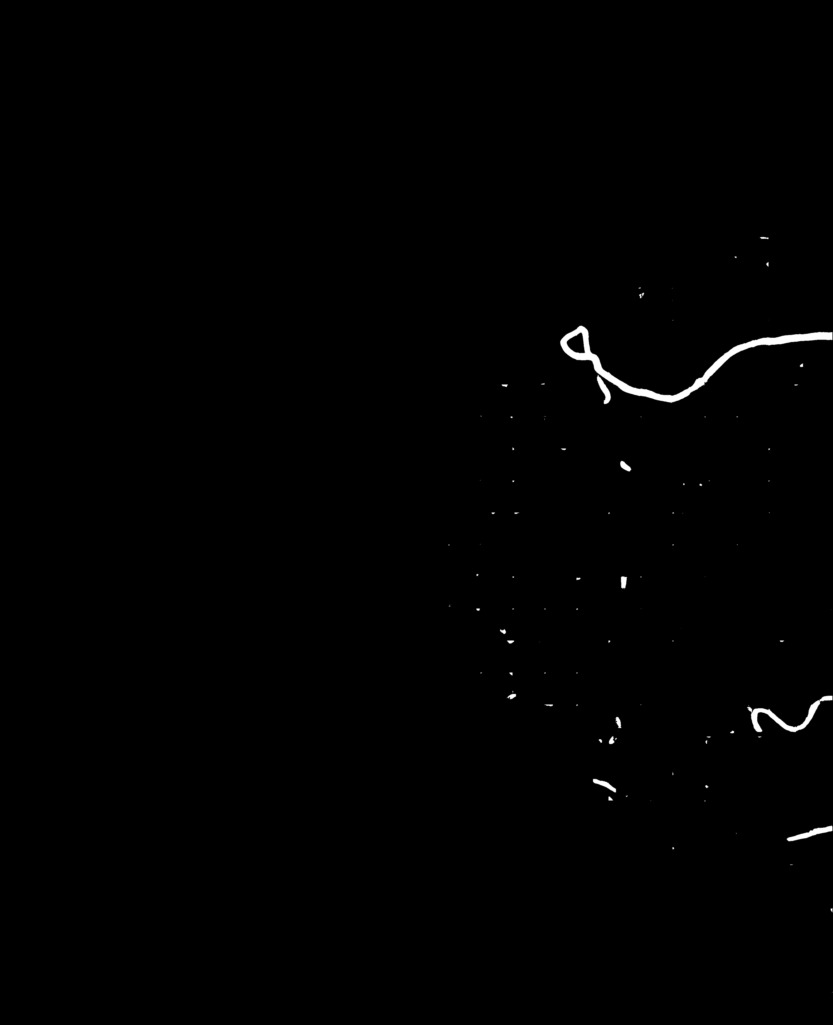

In [12]:
Gray.(results[:,:,1])

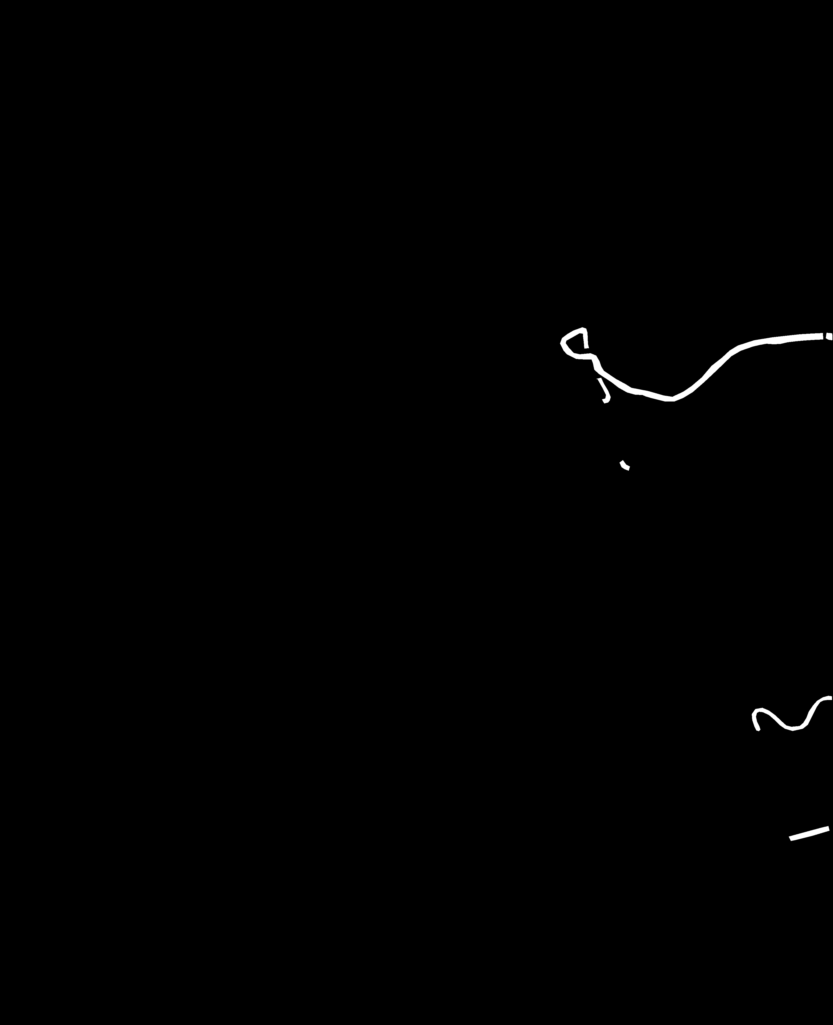

In [10]:
Gray.(temp_y)

In [11]:
# imshow(results)

In [12]:
# sum(results)

In [13]:
# for epoch_idx = epoch_start:2:epoch_end
#     save("noise_sample_epoch_$epoch_idx.png", Gray.(results[:,:,epoch_idx]))
# end